<font size="3">
Celem projektu jest zaimplementowanie i przeprowadzanie analizy porównawczej trzech algorytmów wyznaczania wartości i wektorów własnych macierzy z pokazaniem co najmniej dwóch przykładów zastosowania w analizie danych (np. wyznaczanie minimum formy kwadratowej x^TAx, PCA, SVD, pinv, itp...)

Proponowane aspekty podlegające porównaniu:
<ul>
    <li>ogólność i stabilność metod (analiza dziedziny z możliwością zastosowania),</li>
    <li>zajętość pamięciowa,</li>
    <li>obciążenie procesora,</li>
    <li>wrażliwość na błędy danych,</li>
    <li>ograniczenia co do rozmiaru macierzy.</li>
</ul>

Proponowane algorytmy (proszę samodzielnie wybrać 3):
<ul>
    <li>QR,</li>
    <li>Metoda potęgowa,</li>
    <li>Householder tranformation,</li>
    <li>Lanczos algorithm,</li>
    <li>Jacobie eigenvalue algorithm,</li>
    <li>Locally Optimal Block Preconditioned Conjugate Gradient (LOBPCG)</li>
</ul>
Implementacja algorytmów musi być wykonana w sposób możliwie efektywny i kontrolowany.
Oznacza to, że należy dołożyć starań, aby uruchamiany kod był możliwie zoptymalizowany.

Raport końcowy powinien składać się z czterech części:

<ol>
    <li>wstępu precyzującego jakie algorytmy i w jakim języku zostały zaimplementowane;</li>
    <li>opisu badania, przedstawiającego wybrane przypadki testowe (rodzaje macierzy i jakie cechy tymi macierzami zamierzaliście testować), aspekty porównania oraz (najważniejsze) sposoby i warunki ich pomiaru; w warunkach pomiaru proszę uwzględnić parametry środowiska uruchomieniowego: rozmiar i prędkość pamięci, model procesora, model i typ dysku; niezbędne jest wyszczególnienie wszystkich zastosowanych optymalizacji algorytmów;</li>
    <li>sekcji z wynikami przedstawionymi w odpowiedniej formie wizualnej;</li>
    <li>podsumowania, odnoszącego się do wyników, obiektywnie zestawiających cechy charakterystyczne tych algorytmów; należy skonfrontować uzyskane wyniki ze spodziewanymi; warto odnieść się w dyskusji do aspektu związane z implementacją algorytmów.
    </li>
</ol>
W raporcie końcowym należy między innymi załączyć wykresy prezentujące przebiegi procesu zbiegania się do rozwiązania.

### Pierwszy kamień milowy (10.05 23:59)
- implementacja trzech algorytmów (potęgowa, jacobi, qr),
- optymalizacja (typy, ?),
- testy - wstępne, różne wielkości macierzy, na razie losowe macierze?,
- sprawozdanie - wstępny opis algorytmów, krótki, złożoność obliczeniowa, charakterystka (podział na podstawie obrazka z http://home.agh.edu.pl/~chwiej/mn/problem_wlasny_2016.pdf), wstępny wykres zbieżności, krótki opis testów (tabelka).


### Materiały: 
- performance - https://docs.julialang.org/en/v1/manual/performance-tips/
- Python różnice - https://docs.julialang.org/en/v1/manual/noteworthy-differences/#Noteworthy-differences-from-Python
- http://home.agh.edu.pl/~chwiej/mn/problem_wlasny_2016.pdf
- http://ucidatascienceinitiative.github.io/IntroToJulia/
- https://cheatsheets.quantecon.org/
- http://ucidatascienceinitiative.github.io/IntroToJulia/Html/ArraysAndMatrices
- https://annotate.net/user/Robert-Szmur%C5%82o/awid-05?passid=54561B31-E992-FE1A-5D9E-415434D1D852

In [1]:
A = [45 1 4;
    2 56 1;
    5 9 50]

3×3 Array{Int64,2}:
 45   1   4
  2  56   1
  5   9  50

## Metoda Potęgowa

In [2]:
# using Pkg
# Pkg.add("PyPlot")

In [2]:
using LinearAlgebra
using BenchmarkTools

In [3]:
using PyPlot

In [4]:
function potegowa(A, l::Integer)
    n = size(A, 1)
    x = ones(n, 1)
#     local x1
    for i in 1:l
#         x1 = x  # why do we need x from step i-1 
        x = A * x
        x = x / norm(x)
    end
#     λ = x'*A*x/(x'*x)  # why is x1 used here
    λ = x'*A*x
    return λ, x
end

potegowa (generic function with 1 method)

In [108]:
# Ta macierz ma wartości własne zespolone, ale największa jest rzeczywista i liczy poprawnie
A = [-0.818231  -0.495184   -0.133293   0.70199    -0.999506
  0.843086   0.0847109  -1.67399    0.171253    0.128142
 -1.96322    2.07188    -0.336791   0.0795664  -0.540878
 -1.33479    0.24888    -0.60913   -0.0847137   1.1221
 -1.23948    0.202065    2.12274    0.0489309   1.58457]
display(eigen(A))
potegowa(A, 100)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
  -0.3796551222490756 - 1.7523706127992362im
  -0.3796551222490756 + 1.7523706127992362im
 -0.34027781249688294 - 1.2953137826513144im
 -0.34027781249688294 + 1.2953137826513144im
   1.8694110694919202 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
   0.240242-0.0197955im    0.240242+0.0197955im  …     0.156275+0.0im
   0.152103-0.416811im     0.152103+0.416811im         -0.03923+0.0im
    0.57663-0.0im           0.57663+0.0im           0.000390085+0.0im
 -0.0372778-0.527641im   -0.0372778+0.527641im        -0.573202+0.0im
  -0.249147+0.265806im    -0.249147-0.265806im        -0.803416+0.0im

([1.8613465464459142], [-0.1521211099941537; 0.05034984358724556; … ; 0.5844368371502435; 0.7954055458992091])

In [65]:
# Dla tej macierzy potegowa jest rozbiezna, dwie najwieksze wartości własne są równe i zespolone
# https://math.unice.fr/~frapetti/CorsoF/cours4part2.pdf
# Jeśli macierz o wartościach rzeczywistych ma zespolone wartości własne, to występują one zawsze w parach + i - 
# W takich przypadkach metoda potęgowa będzie rozbieżna
# Some eigenvalues can be complex-valued but if the matrix is
# real-valued, the complex eigenvalues will appear in complex conjugate pairs.
# https://people.math.sc.edu/meade/math526-F05/labs/lab12-PartI.pdf
A = [-1.1055     -0.67013    0.572708  -0.654804   -0.00826613
 -1.29232    -0.550262  -0.454326  -1.47285     0.583418
  0.419839   -2.38968    0.724242   0.0865692  -2.60346
  0.0936464  -0.788076   1.27992   -0.708528   -0.0224423
 -0.53259    -1.41977    1.14853   -2.13332    -1.29399]
display(eigen(A))
potegowa(A, 10000)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -1.8635055554603985 - 2.2328437309920943im
 -1.4878683281352536 + 1.8943160025216115im
 -0.8429050922550397 - 0.045004335711459224im
 -0.6434371974571985 - 1.5342361303419474im
  1.9036781733078914 - 0.0822318054761032im
vectors:
5×5 Array{Complex{Float64},2}:
  -0.177436+0.457229im  0.0643302-0.0948968im  …  0.0908536-0.0627767im
   0.184969+0.227261im   0.154844-0.0870765im     -0.451236+0.0126191im
   0.581279+0.0im        0.670189+0.0im            0.725712+0.0im
 -0.0536516+0.22893im     -0.1046-0.343406im       0.493673+0.00947003im
   0.377593+0.371278im   0.434214-0.434435im       0.116484+0.00153051im

(Complex{Float64}[-1.8635055554603992 - 2.2328437309920988im], Complex{Float64}[0.28646740752665084 + 0.39809351896697903im; 0.29136658846612573 - 0.03109015241884338im; … ; 0.16262289946954828 + 0.1698270153125284im; 0.517134627598024 - 0.11399742624430172im])

In [104]:
# Dla tej macierzy jest zbieżna pomimo, że największa wartość własna jest zespolona
# Ogólnie, jeśli wartości w macierzy są zespolone, to liczy poprawnie
A = [45-2im 1 4;
    2 56 1;
    5 9 50]
display(eigen(A))
potegowa(A, 100)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
3-element Array{Complex{Float64},1}:
 41.674155546205995 - 4.386846308805374im
  50.57853009350467 + 2.956377420948265im
  58.74731436028921 + 0.43046888785710435im
vectors:
3×3 Array{Complex{Float64},2}:
   -0.529412+0.397869im    0.406625-0.115539im   0.215967-0.213384im
 0.000758981-0.0558311im  -0.286308-0.0606935im  0.470134-0.0578787im
    0.747198+0.0im         0.857701+0.0im         0.82671+0.0im

(Complex{Float64}[58.74731399211141 + 0.4304686086574243im], Complex{Float64}[0.3012365248344199 + 0.037823513442226495im; 0.3361497464051707 + 0.33373580515474044im; 0.511108867561302 + 0.6497825973248496im])

In [63]:
# Dwie największe wartości własne są równe - bardzo wolno zbieżna (Powinna się w ogóle zbiegać?)
A = [-2 0 1
    1 1 0
    0 0 -2]
display(eigen(A))
potegowa(A, 1000)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 -2.0
 -2.0
  1.0
vectors:
3×3 Array{Float64,2}:
  0.948683  -0.948683   0.0
 -0.316228   0.316228   1.0
  0.0        4.213e-16  0.0

([-2.0020041345679496], [-0.9487449407083962; 0.3160370588509821; 0.001901292466349487])

In [9]:
A = randn(5,5)
display(eigen(A))
potegowa(A, 1000)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -1.1598710731079471 - 0.3462555890599993im
 -1.1598710731079471 + 0.3462555890599993im
  1.2000275509723277 - 1.1322655840927116im
  1.2000275509723277 + 1.1322655840927116im
  1.2580091092032046 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
   -0.336485-0.158647im     -0.336485+0.158647im   …  -0.322818+0.0im
    0.330308+0.0265454im     0.330308-0.0265454im     -0.646265+0.0im
    0.173412+0.033089im      0.173412-0.033089im       0.258045+0.0im
 -0.00411499-0.0336207im  -0.00411499+0.0336207im     0.0694608+0.0im
   -0.848226-0.0im          -0.848226+0.0im           -0.637745+0.0im

([0.9838225614394718], [0.2624286849324827; 0.7001711851526763; … ; 0.06648226718235999; 0.443790389057734])

In [61]:
display(eigen(A))
potegowa(A, 1000)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 -2.0
 -2.0
  1.0
vectors:
3×3 Array{Float64,2}:
  0.948683  -0.948683   0.0
 -0.316228   0.316228   1.0
  0.0        4.213e-16  0.0

([-2.000200041334593], [-0.9486896066398895; 0.3162087826714628; 0.00018977587650327834])

In [58]:
A = [45-2im 1 4;
    2 56 1;
    5 9 50]

3×3 Array{Complex{Int64},2}:
 45-2im   1+0im   4+0im
  2+0im  56+0im   1+0im
  5+0im   9+0im  50+0im

In [18]:
potegowa(A, 150)

(Complex{Float64}[58.32035147497521 - 0.1581480623338365im], Complex{Float64}[0.23301842893186753 - 0.14267172512534126im; 0.5224217835267352 - 0.2219682727761108im; 0.7110614458432022 - 0.3123209516519719im])

In [16]:
eigen(A)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
3-element Array{Complex{Float64},1}:
 42.767769067188766 - 1.5612220224001732im
  49.91187945785948 - 0.28062991527043274im
 58.320351474951764 - 0.1581480623293987im
vectors:
3×3 Array{Complex{Float64},2}:
   0.875255+0.0im          0.518088-0.167385im   0.270721-0.0369183im
 -0.0967058+0.00423414im  -0.295483+0.0686078im   0.56758+0.00686323im
  -0.464266+0.0949521im    0.782016+0.0im        0.776629+0.0im

In [21]:
@btime potegowa(A, 100)

  28.099 μs (604 allocations: 44.09 KiB)


([58.34154096965294], [0.275294750732188; 0.5667684374955316; 0.7765219497723012])

In [22]:
function potegowav2(A, l::Integer)
    n = size(A, 1)
#     x = ones(Float64, n, 1)
    x = (rand(n) .+ 0.01) .% 1 
#     x1 = Array{Float64}
    for i in 1:l
#         x1 = x  # why do we need x from step i-1 
        x = A * x
        x = x / norm(x)
    end
    λ = x'*A*x/(x'*x)
#     λ = x'*A*x1/(x'*x1)  # why is x1 used here
    return λ, x
end

potegowav2 (generic function with 1 method)

In [23]:
# potegowav2(A, 1000)

In [24]:
# @btime potegowav2(A, 100)

In [25]:
eigen(A)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 42.691264195502654
 49.967194893786406
 58.34154091071096
vectors:
3×3 Array{Float64,2}:
 -0.87227     0.556929  -0.275295
  0.0950383  -0.31221   -0.566768
  0.479701    0.769646  -0.776522

In [26]:
# function x = rayleigh(A, epsilon, mu, x)
#   x = x / norm(x);
#   y = (A - mu * eye(rows(A))) \ x; 
#   lambda = y' * x;
#   mu = mu + 1 / lambda
#   err = norm(y - lambda * x) / norm(y)

#   while err > epsilon
#     x = y / norm(y);
#     y = (A - mu * eye(rows(A))) \ x;
#     lambda = y' * x;
#     mu = mu + 1 / lambda
#     err = norm(y - lambda * x) / norm(y)
#   end

# end

In [106]:
function rayleigh_power_method(A::Symmetric{Float64}, l::Integer)
    n = size(A, 1);
    x = ones(n, 1);
    mI = eye(n);
    mu = rand(1)[1];
        
    x = x / norm(x);
    y = (A - mu*mI) * x;
    
    for i in 1:l
        x = y / norm(y);
        y = (A - mu*mI) * x;
        λ = y' * x;
        mu = mu + 1 / λ[1];
    end
    λ = x'*A*x
    y = y / norm(y);
    return λ, y
end

rayleigh_power_method (generic function with 1 method)

In [28]:
function typed_power_method(A::Symmetric{Float64}, l::Integer)
    n::Int64 = size(A, 1)
    x::Array{Float64} = ones(n, 1)
    for i::Int64 in 1:l
        x = A * x
        x = x / norm(x)
    end
    λ::Float64 = (x'*A*x)[1]
    return λ, x
end

typed_power_method (generic function with 1 method)

## Metoda Jacobiego

#### Macierz symetryczna o rzeczywistych wartościach zawsze ma rzeczywiste wartości własne. Czy chcemy na wejście dopuszczać wartości zespolone?

In [109]:
display(B)

LoadError: [91mUndefVarError: B not defined[39m

In [5]:
function eye(n)
    return Matrix{Float64}(I,n,n)
end

function maxst(A)
    s = 1;
    t = 2;
    n = size(A,1);

    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
            s = r;
            t = c;
            end
        end
    end
    return s,t
end


maxst (generic function with 1 method)

In [6]:
function jacobi(A, l::Integer)
    n = size(A,1);
    for i = 1:l
        s,t = maxst(A);
        d = sqrt((A[s,s] - A[t,t])^2 + 4*A[s,t]^2);
        sin2t = 2*A[s,t]/d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2*(1+cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1+ cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        A = R'*A*R;
    end
    return A
end

jacobi (generic function with 1 method)

In [112]:
n = 20
A = randn(n,n)
B = Symmetric(A)

20×20 Symmetric{Float64,Array{Float64,2}}:
  0.52452    -1.77321    -0.774372   …   0.0663018  -0.488123  -0.854396
 -1.77321    -1.16885    -0.332618       0.0895595  -1.06821    0.202813
 -0.774372   -0.332618   -0.108378      -1.55522    -0.309893   1.68159
  0.7166     -0.0245268  -0.746283       0.260813    0.510583  -0.306072
 -0.33639    -2.64834     1.65784       -1.8199     -0.818416   0.328254
 -1.07552    -0.0936822   1.45526    …  -1.78331    -1.83483    0.205725
  0.165832   -0.541807   -0.678762      -0.476763    1.00397    0.444632
  1.11075     1.31962    -0.630932      -0.815773   -1.46709   -0.597956
 -0.234121   -0.201277   -0.234297      -0.81825    -1.82521    0.588773
  1.3        -1.07442    -1.06954       -0.117511   -0.658211   1.00739
  0.579684    0.742188   -1.04231    …   2.84142    -1.0772    -0.889995
  0.594803    0.678093    0.427835      -1.29506     0.74082   -0.121851
  1.84651    -0.904576   -1.04744       -1.03244     1.0987     0.00728088
  0.8633

In [113]:
AJ = jacobi(B, 1500)
display(AJ)
diag(AJ)[end:-1:1]

20×20 Array{Float64,2}:
  7.74631      -3.64225e-83   7.82064e-85  …   4.96029e-155   3.72741e-104
  4.63105e-16   7.10279      -1.59578e-88      7.41957e-158  -4.11805e-84
  1.27186e-16   2.1727e-16    5.35146         -3.06929e-92    2.99627e-95
 -3.82021e-18   1.97836e-18  -1.25239e-15     -1.64599e-83   -3.21722e-86
  2.44015e-16  -6.86895e-17  -6.36886e-17     -2.74156e-82   -1.62742e-83
  2.9409e-16   -3.87636e-16  -1.87024e-16  …  -2.39702e-94    4.02153e-87
  4.56489e-17   4.0334e-16    1.20248e-16      2.47083e-83    3.84027e-93
  2.09351e-17   1.2176e-16    2.12415e-16      3.33401e-94    2.43681e-83
  8.26259e-17  -3.48143e-17  -2.74262e-16     -2.35958e-89    3.71158e-84
  2.77976e-17  -1.00266e-16  -2.60961e-16      8.44392e-86    4.21351e-96
  3.86772e-17  -5.83642e-17   9.14506e-17  …   5.32402e-84   -9.54991e-94
 -2.50358e-17  -1.73285e-17  -3.42049e-16     -9.46057e-87    4.92892e-91
  2.71951e-16  -2.36293e-16   2.16463e-16     -2.99627e-95   -1.1131e-93
 -2.0642e-16  

20-element Array{Float64,1}:
 -7.516077372157684
 -6.610616934506254
 -6.341686867195648
 -5.507180142437151
 -4.4938086937670345
 -3.0627294846704083
 -2.747687184083552
 -2.5769239214995765
 -1.5365402642236872
 -1.4307391631354853
 -0.1762344861920213
  1.1398714185092342
  2.0454548570360416
  2.679478565383572
  3.694036926623665
  4.080513959244551
  4.9487548802893055
  5.351457273876637
  7.102789093169036
  7.746307389810969

In [41]:
eigen(B)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
20-element Array{Float64,1}:
 -8.207503270279707
 -7.194225306933484
 -5.729589522248755
 -3.952718332623233
 -3.668934300968891
 -2.412598230056414
 -1.8948344119305371
 -1.1608122961991683
 -0.5711506620351834
 -0.41431336679717923
  0.6386565397039741
  1.000697623489435
  2.2687685441388092
  2.8515936574793095
  2.9914184584707026
  3.973238787773431
  4.617809011420281
  5.649893223664945
  5.875654663744747
  7.83914952712463
vectors:
20×20 Array{Float64,2}:
 -0.315034   -0.132642    0.530256    …   0.0571949  -0.440782
 -0.125463    0.174036    0.00397885     -0.226221    0.0120995
 -0.105024    0.208902    0.317066       -0.261962    0.164335
 -0.354231    0.0748401  -0.106763       -0.168465   -0.195131
 -0.1627     -0.399857    0.208857       -0.0368588   0.263381
  0.111046    0.333521    0.0800341   …   0.188498    0.290939
  0.375472   -0.0422454   0.104522       -0.177245    0.000557692
 -0.378564   -0.0960

In [10]:
# Nie wiem jak sprawić, żeby Jacobi poprawnie liczył zespolone wartości 
# Problemem moga być funkcje sign i abs
# abs zwraca odległość, a sign taką wartość, że abs(sign(x)) == 1
display(sign(-1-1im))
abs(sign(-1-1im))

-0.7071067811865475 - 0.7071067811865475im

0.9999999999999999

In [21]:
function eye_complex(n)
    return Matrix{ComplexF64}(I,n,n)
end

eye_complex (generic function with 1 method)

In [51]:
function jacobi(A, l::Integer)
    n = size(A,1);
    for i = 1:l
        s,t = maxst(A);
        d = sqrt((A[s,s] - A[t,t])^2 + 4*A[s,t]^2);
        sin2t = 2*A[s,t]/d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2*(1+cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1+ cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye_complex(n);  # normale eye wyrzucało błąd, bo macierz była Float64
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        A = R'*A*R;
    end
    return A
end

jacobi (generic function with 1 method)

In [52]:
A = [-0.818231  -0.495184+1im   -0.133293   0.70199    -0.999506
  0.843086   0.0847109  -1.67399+9im    0.171253    0.128142
 -1.96322    2.07188    -0.336791   0.0795664-3im  -0.540878
 -1.33479    0.24888    -0.60913   -0.0847137   1.1221
 -1.23948    0.202065    2.12274    0.0489309   1.58457]
display(eigen(A))
diag(jacobi(A, 100))[end:-1:1]

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
  -3.0728261600789883 - 4.343423148654246im
  -1.5807444839941889 + 0.6265104406562688im
 -0.03496384287088344 + 0.2233104118733166im
   2.5500626666657067 + 0.14802652783510567im
    2.568017020278361 + 3.345575768289563im
vectors:
5×5 Array{Complex{Float64},2}:
  -0.150365-0.155104im    0.723047+0.0im        …   0.111561+0.214583im
   0.835492+0.0im          0.39402+0.293342im       0.843244+0.0im
  -0.325707+0.338137im  0.00205348+0.170083im       0.245722-0.272711im
 -0.0335178+0.101409im    0.293064+0.205304im      -0.110834+0.00171954im
 -0.0591951-0.141254im    0.268465-0.0828247im      -0.18808-0.219173im

5-element Array{Complex{Float64},1}:
              1.58457 + 0.0im
           -0.0847137 + 0.0im
 4.656447900319948e28 + 1.9938966858134464e28im
 4.656447900319948e28 + 1.9938966858134464e28im
            -0.818231 + 0.0im

In [42]:
n = 5
A = randn(n,n)
# A[1,1] = A[1,1] + 1im
B = Symmetric(A)
B

5×5 Symmetric{Float64,Array{Float64,2}}:
  1.15735   0.30399      -1.36958   -1.13302       0.223713
  0.30399   0.250663      1.19506    0.000491689   1.80991
 -1.36958   1.19506      -2.04266    0.535929     -0.194846
 -1.13302   0.000491689   0.535929  -1.1917       -0.602091
  0.223713  1.80991      -0.194846  -0.602091      0.490179

In [28]:
n = 5
A = [1.19712+1im    0.429355   -0.628454   0.65987   -0.496139
 -0.402522   0.0229771   0.832969  -0.598849   0.420017
 -2.39558   -1.00399     0.277438  -0.606223   0.0329519
  1.40605    0.578298    0.73771    1.04196    0.461577
 -1.26858    0.936624    0.689062   0.86382   -1.47906]
A[1,1] = A[1,1] + 1im
B = Symmetric(A)
B

5×5 Symmetric{Complex{Float64},Array{Complex{Float64},2}}:
   1.19712+2.0im   0.429355+0.0im  …    0.65987+0.0im  -0.496139+0.0im
  0.429355+0.0im  0.0229771+0.0im     -0.598849+0.0im   0.420017+0.0im
 -0.628454+0.0im   0.832969+0.0im     -0.606223+0.0im  0.0329519+0.0im
   0.65987+0.0im  -0.598849+0.0im       1.04196+0.0im   0.461577+0.0im
 -0.496139+0.0im   0.420017+0.0im      0.461577+0.0im   -1.47906+0.0im

In [29]:
# eigen(B) nie działa dla B (Symmetric{Complex{Float64},Array{Complex{Float64},2}})
display(eigen(B))
jacobi(B, 10000)

LoadError: [91mMethodError: no method matching eigen!(::Symmetric{Complex{Float64},Array{Complex{Float64},2}}; permute=true, scale=true, sortby=LinearAlgebra.eigsortby)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  eigen!([91m::SymTridiagonal{var"#s828",V} where V<:AbstractArray{var"#s828",1} where var"#s828"<:Union{Float32, Float64}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\LinearAlgebra\src\tridiag.jl:279[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m[39m
[91m[0m  eigen!([91m::SymTridiagonal{var"#s828",V} where V<:AbstractArray{var"#s828",1} where var"#s828"<:Union{Float32, Float64}[39m, [91m::UnitRange[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\LinearAlgebra\src\tridiag.jl:282[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m[39m
[91m[0m  eigen!([91m::SymTridiagonal{var"#s828",V} where V<:AbstractArray{var"#s828",1} where var"#s828"<:Union{Float32, Float64}[39m, [91m::Real[39m, [91m::Real[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\LinearAlgebra\src\tridiag.jl:287[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m[39m
[91m[0m  ...[39m

In [34]:
A

5×5 Array{Float64,2}:
  1.19712    0.429355   -0.628454   0.65987   -0.496139
 -0.402522   0.0229771   0.832969  -0.598849   0.420017
 -2.39558   -1.00399     0.277438  -0.606223   0.0329519
  1.40605    0.578298    0.73771    1.04196    0.461577
 -1.26858    0.936624    0.689062   0.86382   -1.47906

In [32]:
B[1,1] = B[1,1] - 1im

LoadError: [91mInexactError: Float64(0.9642101738140003 - 1.0im)[39m

In [25]:
n = 5
A = randn(n,n)
B = Symmetric(A)
B[1,1] = B[1,1] + 1im
# A = [45 1 4;
#     1 56 1;
#     4 1 50]
display(eigen(B))
jacobi(B, 10000)

LoadError: [91mMethodError: no method matching Symmetric(::Type{Complex{Float64}}, ::Array{Float64,2})[39m

## Metoda QR
https://www.programmersought.com/article/78156250334/

In [62]:
# TODO zobaczyć czy for po kolumnach
function mgs(A)
    n = size(A,1);
    R = zeros(n, n);
    Q = zeros(n, n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]'*v;
            v = v - R[i,j]*Q[:,i];
        end
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    return Q,R
end



mgs (generic function with 1 method)

In [43]:
# AS = [1 5 6;
#     5 23 9;
#     6 9 18]

In [44]:
test, test2 = mgs(A);

In [45]:
display(test)
display(test2)

20×20 Array{Float64,2}:
 -0.213599    -0.0820045  -0.511881    …   0.265647     0.121409   -0.0199483
  0.300034    -0.12093     0.231437       -0.237649    -0.0217774  -0.150589
 -0.0408529   -0.305919    0.122558       -0.0325277   -0.0600703   0.362881
  0.211824     0.340492   -0.122278        0.131316     0.237774   -0.235137
 -0.12024     -0.131938    0.104184       -0.141607     0.0374341   0.274401
 -0.0079206   -0.247476    0.139513    …   0.00209956  -0.263349   -0.0163762
 -0.110417     0.11878     0.450021        0.417484    -0.0534202  -0.35269
  0.323727    -0.37563    -0.112659        0.506333    -0.329708   -0.155122
 -0.457038    -0.1173     -0.315749       -0.135852    -0.28301    -0.384918
  0.14921     -0.378381   -0.10806         0.101894     0.362728    0.0694336
 -0.177846    -0.226845    0.140372    …  -0.261762    -0.261241   -0.0607644
  0.427025     0.0242859  -0.0961858       0.0106022   -0.277706    0.0217755
 -0.205107    -0.149274   -0.0754195       0.135

20×20 Array{Float64,2}:
 4.22659  0.896443   0.195036  …  -1.15236    -0.520107    0.391409
 0.0      4.86284   -1.43837      -0.384077    0.224741    1.08711
 0.0      0.0        3.1888       -2.59521    -0.306073   -0.626721
 0.0      0.0        0.0           0.839743    0.586607   -2.27618
 0.0      0.0        0.0          -0.635074    1.3993     -0.354654
 0.0      0.0        0.0       …  -0.571668    0.789506    1.25371
 0.0      0.0        0.0          -0.0154209  -0.0363676   0.0657521
 0.0      0.0        0.0          -1.96515    -0.351756    0.493018
 0.0      0.0        0.0          -1.04454    -0.0551928  -1.05088
 0.0      0.0        0.0          -0.269499    1.38436    -0.713698
 0.0      0.0        0.0       …  -0.78209    -0.535409    0.833188
 0.0      0.0        0.0          -0.40065    -0.48169     1.85814
 0.0      0.0        0.0          -1.16829     0.312716   -0.137238
 0.0      0.0        0.0          -0.978322    0.71987     0.619829
 0.0      0.0        0.0    

In [76]:
function QR_eigen(A, l::Integer)
    Q,R = mgs(A)  # Jeśli chcemy mieć później dostęp do tych macierzy, to muszą być zadeklarowane poza pętlą for
    for k = 1:l
        Q,R = mgs(A);
        A = R*Q;
    end
    A
end

QR_eigen (generic function with 1 method)

In [20]:
# function QR_eigen_rand(l::Integer)
#     A = rand(5, 5);
#     A = A - tril(A,-1)
#     display(eigen(A))
#     Q,R = mgs(A)
#     for k = 1:l
#         Q,R = mgs(A);
#         A = R*Q;
#     end
#     diag(A)[end:-1:1]
#     A
# end

In [21]:
# QR_eigen_rand(100)

In [51]:
diag(QR_eigen(B, 1000))[end:-1:1]

20-element Array{Float64,1}:
 -0.4143133667971839
 -0.5711506620351857
  0.6386565397039676
  1.0006976234894307
 -1.1608122961991727
 -1.8948344119305385
  2.2687685441387977
 -2.4125982300564206
  2.851593657479312
  2.9914184584707026
 -3.6689343009688873
 -3.949568836670567
  3.9700892918207593
  4.617809011420274
  5.649893223663137
 -5.729589522246941
  5.875654663744749
 -7.194225306933488
  7.839149527124623
 -8.20750327027972

In [55]:
diag(QR_eigen(B, 150))

20-element Array{Float64,1}:
 -8.20747057511617
  7.8391168318177185
 -7.194225306790129
 -1.229365836176177
  1.4144498695891856
  5.610874331747934
  4.617809011420274
 -1.7778584940462914
  1.7983789461959656
 -3.6689342979683732
  2.9914184444935175
  2.8515936714564973
 -2.4125981665853065
  2.2687684806676836
 -1.8948344119305385
 -1.1608122961991727
  1.0006976234894307
  0.6386565397039622
 -0.5711506620351803
 -0.4143133667971839

In [54]:
eigen(B)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
20-element Array{Float64,1}:
 -8.207503270279707
 -7.194225306933484
 -5.729589522248755
 -3.952718332623233
 -3.668934300968891
 -2.412598230056414
 -1.8948344119305371
 -1.1608122961991683
 -0.5711506620351834
 -0.41431336679717923
  0.6386565397039741
  1.000697623489435
  2.2687685441388092
  2.8515936574793095
  2.9914184584707026
  3.973238787773431
  4.617809011420281
  5.649893223664945
  5.875654663744747
  7.83914952712463
vectors:
20×20 Array{Float64,2}:
 -0.315034   -0.132642    0.530256    …   0.0571949  -0.440782
 -0.125463    0.174036    0.00397885     -0.226221    0.0120995
 -0.105024    0.208902    0.317066       -0.261962    0.164335
 -0.354231    0.0748401  -0.106763       -0.168465   -0.195131
 -0.1627     -0.399857    0.208857       -0.0368588   0.263381
  0.111046    0.333521    0.0800341   …   0.188498    0.290939
  0.375472   -0.0422454   0.104522       -0.177245    0.000557692
 -0.378564   -0.0960

In [26]:
# TODO zobaczyć czy for po kolumnach
function mgs(A)
    n = size(A,1);
    R = zeros(n, n);
    Q = zeros(n, n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]'*v;
            v = v - R[i,j]*Q[:,i];
        end
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    return Q,R
end

function QR_eigen(A, l::Integer)
    Q,R = mgs(A)  # Jeśli chcemy mieć później dostęp do tych macierzy, to muszą być zadeklarowane poza pętlą for
    for k = 1:l
        Q,R = mgs(A);
        A = R*Q;
    end
    A
end

QR_eigen (generic function with 1 method)

In [136]:
QR_eigen(A, 1000)

5×5 Array{Float64,2}:
 -1.42474      -1.71118      -0.492967  -2.31442    -0.200575
  0.269415     -0.270879      1.14357    0.0245453  -1.1508
  1.06221e-39  -3.52311e-39   0.839722   0.4682     -0.923512
  0.0           0.0           0.0        0.384201   -1.15134
  0.0           0.0           0.0        0.0         0.0399073

In [121]:
A

5×5 Array{Float64,2}:
 -0.449068  -1.38815   -0.480425   1.76343   -1.75403
 -0.662838  -0.152295  -0.325421  -1.027      0.00878161
  0.430706   0.194898   0.453019  -0.883366   0.884526
  0.521313   0.764715   0.17505    0.197992   0.487
 -0.882232  -0.216417  -1.24147   -0.840407  -0.481432

In [123]:
# QR decomposition a zespolone wartości własne
# https://math.stackexchange.com/questions/3072758/is-it-possible-to-find-complex-eigenvalues-with-qr-decomposition/3072781
# https://scicomp.stackexchange.com/questions/30407/how-does-the-qr-algorithm-applied-to-a-real-matrix-returns-complex-eigenvalues
# Użycie eigen(x) na wyniku QR_eigen liczy wszystkie wartości własne?
display(eigen(A))
eigen(QR_eigen(A, 1000))

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -0.8478073996944057 - 0.3580106740384312im
 -0.8478073996944057 + 0.3580106740384312im
 0.03990734863183874 + 0.0im
  0.3842007903147903 + 0.0im
  0.8397222972684841 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
   0.805298-0.0im         …   0.518851+0.0im   0.797972+0.0im
  0.0735172+0.00167874im     -0.121706+0.0im  -0.405747+0.0im
  -0.439638+0.0120077im       0.372416+0.0im  0.0464177+0.0im
  -0.331997+0.024537im       -0.394851+0.0im  -0.141395+0.0im
 -0.0884749+0.184419im       -0.649138+0.0im  -0.420074+0.0im

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -0.8478073996944064 - 0.3580106740384303im
 -0.8478073996944064 + 0.3580106740384303im
 0.03990734863183762 + 0.0im
  0.3842007903147926 + 0.0im
  0.8397222972684832 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
     0.929501-0.0im         …   0.219555+0.0im  -0.544377+0.0im
    -0.313384+0.194469im       -0.718379+0.0im   0.534032+0.0im
 -1.23556e-39+7.6672e-40im     -0.473121+0.0im   0.646888+0.0im
          0.0-0.0im             0.460309+0.0im        0.0+0.0im
          0.0-0.0im                  0.0+0.0im        0.0+0.0im

In [127]:
eigen(QR_eigen(A, 1000)[1:2, 1:2])

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
2-element Array{Complex{Float64},1}:
 -0.8478073996944063 - 0.35801067403843034im
 -0.8478073996944063 + 0.35801067403843034im
vectors:
2×2 Array{Complex{Float64},2}:
  0.929501-0.0im        0.929501+0.0im
 -0.313384+0.194469im  -0.313384-0.194469im

In [94]:
display(eigen(A))
diag(QR_eigen(A, 1500))

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -0.8478073996944057 - 0.3580106740384312im
 -0.8478073996944057 + 0.3580106740384312im
 0.03990734863183874 + 0.0im
  0.3842007903147903 + 0.0im
  0.8397222972684841 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
   0.805298-0.0im         …   0.518851+0.0im   0.797972+0.0im
  0.0735172+0.00167874im     -0.121706+0.0im  -0.405747+0.0im
  -0.439638+0.0120077im       0.372416+0.0im  0.0464177+0.0im
  -0.331997+0.024537im       -0.394851+0.0im  -0.141395+0.0im
 -0.0884749+0.184419im       -0.649138+0.0im  -0.420074+0.0im

5-element Array{Float64,1}:
 -0.5172016003854394
 -1.1784131990033588
  0.839722297268485
  0.38420079031479143
  0.03990734863183806

In [89]:
n = 5
A = randn(n,n)
# B = Symmetric(A)
display(eigen(A))
diag(QR_eigen(A, 1500))

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -0.8478073996944057 - 0.3580106740384312im
 -0.8478073996944057 + 0.3580106740384312im
 0.03990734863183874 + 0.0im
  0.3842007903147903 + 0.0im
  0.8397222972684841 + 0.0im
vectors:
5×5 Array{Complex{Float64},2}:
   0.805298-0.0im         …   0.518851+0.0im   0.797972+0.0im
  0.0735172+0.00167874im     -0.121706+0.0im  -0.405747+0.0im
  -0.439638+0.0120077im       0.372416+0.0im  0.0464177+0.0im
  -0.331997+0.024537im       -0.394851+0.0im  -0.141395+0.0im
 -0.0884749+0.184419im       -0.649138+0.0im  -0.420074+0.0im

5-element Array{Float64,1}:
 -0.5172016003745795
 -1.1784131990142304
  0.8397222972684832
  0.3842007903147926
  0.03990734863183762

In [11]:
#Improved reduction of QR decomposition
function schmidit_QRc(A::Array)
    m,n=size(A)
    Q=zeros(m,n)
    R=zeros(n,n)
    for j in 1:n
        y=A[:,j]
        if j!=1
            for i in 1:j-1
                R[i,j]=Q[:,i]'*y #Note that this has changed
                y=y-R[i,j].*Q[:,i]
            end
        end
        R[j,j]=sqrt(sum(y.^2))
        Q[:,j]=y./R[j,j]
    end
    return Q,R
end

function QR_eigen(A, l::Integer)
    Q,R = schmidit_QRc(A)  # Jeśli chcemy mieć później dostęp do tych macierzy, to muszą być zadeklarowane poza pętlą for
    for k = 1:l
        Q,R = schmidit_QRc(A);
        A = R*Q;
    end
    A
end

QR_eigen (generic function with 1 method)

In [143]:
display(QR_eigen(A, 1000))

5×5 Array{Float64,2}:
 -1.42474      -1.71118      -0.492967  -2.31442    -0.200575
  0.269415     -0.270879      1.14357    0.0245453  -1.1508
  1.06221e-39  -3.52311e-39   0.839722   0.4682     -0.923512
  0.0           0.0           0.0        0.384201   -1.15134
  0.0           0.0           0.0        0.0         0.0399073

In [9]:
#eyes(n) produces a unit matrix of order n, eyes(n,m) produces a matrix with a diagonal of 1
function eyes(m::Int,index::Int=0)
    n=0
    if index==0
        n=m
    else
        n=index
    end
    I=zeros(m,n)
    [I[i,i]=1 for i in 1:min(m,n)]
    return I
end

 #Translation QR algorithm, able to calculate the real and complex eigenvalues ​​of the square matrix
 function shiftQRc(A::Array) #A is a square matrix
    tol=1e-14
    maxiter=500
    m=size(A,1)
    lam=zeros(m,1)
    n=m
    while n>1
        iter=0
        while sort(abs.(A[n,1:n-1]))[end]>tol && iter<maxiter
                         iter=iter+1 #Record the number of qr
                         mu=A[n,n] #Translation amount
            q,r=schmidit_QRc(A-mu*eyes(n))
            A=r*q+mu*eyes(n)
        end
                 if iter<maxiter #block with 1x1
            lam[n]=A[n,n]
            n=n-1
            A=A[1:n,1:n]
                 else#Iteration exceeds the maximum number of iterations, which is considered a 2x2 block
                         #lam is a real number vector and needs to be converted to a complex number vector, otherwise an error will be reported later, and the complex number cannot be directly copied to the real number variable
            lam=complex(lam)
                         disc=(A[n-1,n-1]-A[n,n])^2+4*A[n,n-1]*A[n-1,n] #One element quadratic root formula a^2-4ac
                         temp=sqrt.(disc+0*im)#You need to add 0*im to become a plural in order to make a square
            lam[n]=(A[n-1,n-1]+A[n,n] +temp)/2
            lam[n-1]=(A[n-1,n-1]+A[n,n]-temp)/2
                         n=n-2 #Shrink by 2
            A=A[1:n,1:n]
        end
    end
    if n>0
        lam[1]=A[1,1]
    end
    return lam
end        

shiftQRc (generic function with 1 method)

In [24]:
n = 5
A = randn(n,n)
display(eigen(A).values)
shiftQRc(A)

5-element Array{Complex{Float64},1}:
 -1.0704607735690614 + 0.0im
 -0.6452218789701214 - 1.7656026228870947im
 -0.6452218789701214 + 1.7656026228870947im
  0.9406139155303814 - 0.13793567939493243im
  0.9406139155303814 + 0.13793567939493243im

5×1 Array{Complex{Float64},2}:
 -0.6452218789701191 - 1.765602622887089im
 -0.6452218789701191 + 1.765602622887089im
  -1.070460773569063 + 0.0im
  0.9406139155303795 - 0.13793567939492887im
  0.9406139155303795 + 0.13793567939492887im

In [25]:
@btime shiftQRc(A)

  3.262 ms (55580 allocations: 6.26 MiB)


5×1 Array{Complex{Float64},2}:
 -0.6452218789701191 - 1.765602622887089im
 -0.6452218789701191 + 1.765602622887089im
  -1.070460773569063 + 0.0im
  0.9406139155303795 - 0.13793567939492887im
  0.9406139155303795 + 0.13793567939492887im

In [29]:
QR_eigen(A, 1000)[3,3]

-1.0704607735690617

In [30]:
eigen(A)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 -1.0704607735690614 + 0.0im
 -0.6452218789701214 - 1.7656026228870947im
 -0.6452218789701214 + 1.7656026228870947im
  0.9406139155303814 - 0.13793567939493243im
  0.9406139155303814 + 0.13793567939493243im
vectors:
5×5 Array{Complex{Float64},2}:
   0.634744+0.0im   0.0494783+0.257352im  …  -0.254914+0.0261851im
  -0.721161+0.0im    0.773986-0.0im           0.138443-0.0165782im
  -0.165872+0.0im  0.00980843+0.541631im      0.256866-0.0102621im
 -0.0274093+0.0im   0.0150445-0.108966im      0.726475+0.0im
  -0.220822+0.0im   0.0092101-0.163164im      0.561574+0.0753397im

In [27]:
@btime QR_eigen(A, 1000)

  2.919 ms (53052 allocations: 6.93 MiB)


5×5 Array{Float64,2}:
 -0.389829       1.53429        0.714084     -0.0692419  -0.228741
 -2.07431       -0.900615       1.52085       0.378825   -1.24173
  1.75478e-244   3.36441e-245  -1.07046      -1.05246     0.0793202
 -4.10657e-296   1.55126e-295   1.78518e-51   1.02709     1.77102
  7.91185e-298  -3.44214e-297  -3.73733e-53  -0.014966    0.854134

## Testowanie

### Metoda potęgowa 

1. Macierz z elementami i wektorami własnymi rzeczywistymi

In [56]:
A = randn(5,5)
A = A * diagm(1:5) / A

5×5 Array{Float64,2}:
  4.65149    -0.265141   -0.382523   -0.332124   1.32617
 -0.164906    2.00655    -0.2765     -2.17233   -0.466494
 -0.637335    0.0205827   1.52138    -0.852991  -1.04256
  0.0631756  -0.0978668  -0.0428932   3.89281    0.189759
  0.21066    -0.695087   -0.687774   -0.960114   2.92777

In [57]:
eigvals(A)

5-element Array{Float64,1}:
 1.0
 1.9999999999999993
 2.999999999999999
 4.000000000000003
 5.0000000000000036

In [58]:
λ, X = eigen(A)
i = sortperm(λ, by=abs, rev=true) # sort the eigenvalues in descending order by magnitude
λ = λ[i]; X = X[:,i]              # and re-order λ and X
λ

5-element Array{Float64,1}:
 5.0000000000000036
 4.000000000000003
 2.999999999999999
 1.9999999999999993
 1.0

In [59]:
x = (rand(5) .+ 0.01) .% 1# arbitrary initial vector
# for n = 1:100
#     y = x
#     for i = 1:n
#         y = A*y
#         y = y / norm(y)
#     end
# end
x

5-element Array{Float64,1}:
 0.6595983712991615
 0.31683209024388814
 0.35827567016950956
 0.9715454981056775
 0.9966639972500986

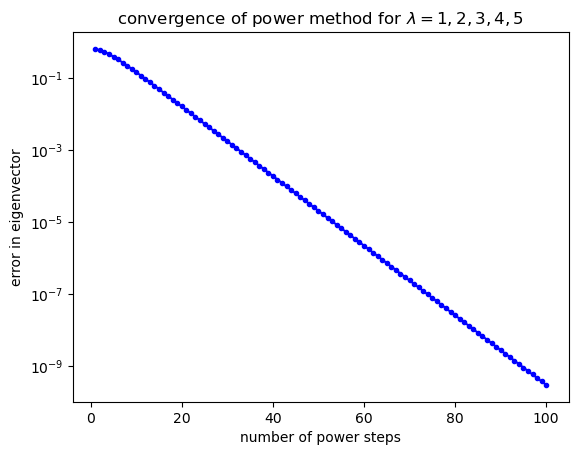

PyObject Text(0.5, 1.0, 'convergence of power method for $\\lambda=1,2,3,4,5$')

In [60]:
d = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    push!(d, min(norm(y - X[:,1]), norm(-y - X[:,1]))) # pick the better of the two signs
end
semilogy(1:length(d), d, "b.-")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")

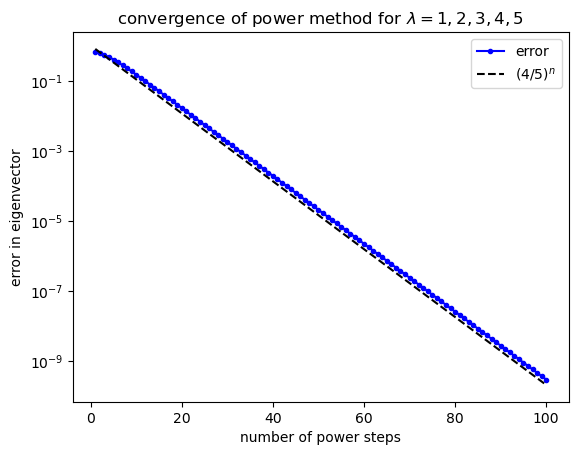

PyObject <matplotlib.legend.Legend object at 0x000000004911DCA0>

In [61]:
semilogy(1:length(d), d, "b.-")
semilogy(1:length(d), (4/5).^(1:length(d)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

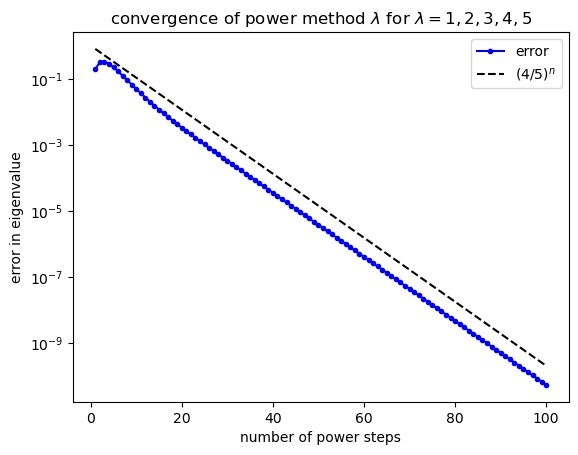

PyObject <matplotlib.legend.Legend object at 0x00000000493AA850>

In [62]:
Δλ = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    λ̃ = (y'A*y) / (y'y)
    push!(Δλ, abs(λ̃ - 5))
end
semilogy(1:length(Δλ), Δλ, "b.-")
semilogy(1:length(Δλ), (4/5).^(1:length(Δλ)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvalue")
title(L"convergence of power method $\lambda$ for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

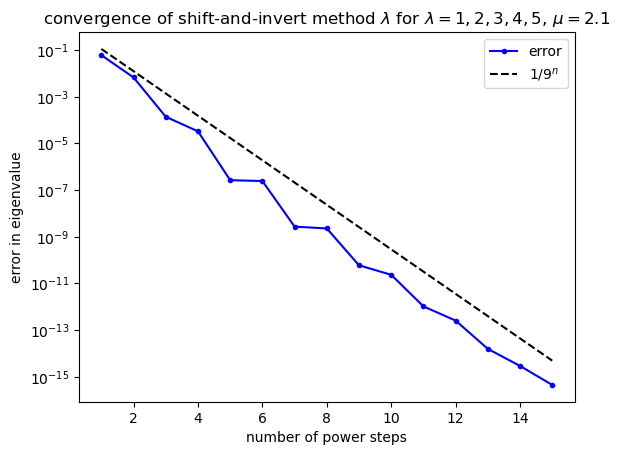

PyObject <matplotlib.legend.Legend object at 0x000000004935AD00>

In [63]:
Δλ = Float64[]
y = x
for i = 1:15
    y = (A - 2.1I) \ y
    y = y / norm(y)
    λ̃ = (y'A*y) / (y'y)
    push!(Δλ, abs(λ̃ - 2))
end
semilogy(1:length(Δλ), Δλ, "b.-")
semilogy(1:length(Δλ), (1/9).^(1:length(Δλ)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvalue")
title(L"convergence of shift-and-invert method $\lambda$ for $\lambda=1,2,3,4,5$, $\mu = 2.1$")
legend(["error", L"1/9^n"])

In [64]:
n = 20
A = randn(n,n)
A = A * diagm(1:n) / A

20×20 Array{Float64,2}:
   32.6164    -0.714505   -6.66997   …   -3.13021    -4.33414    -19.2843
   66.7876     1.14405   -15.908         -5.04507   -15.7864     -68.3098
  -23.696      3.20868     4.15994       -8.15241     1.15989     24.2989
  123.343    -18.198     -26.6017        -7.58444   -21.4698    -110.916
   12.5484    -3.77724    -5.19089        2.26477    -2.37231     -8.34886
  159.231    -19.5268    -30.5622    …   -3.79465   -29.8309    -150.282
   60.4009    -8.21115   -16.6256        -4.3848    -13.4689     -55.861
  104.83     -14.5493    -24.3378        -5.4973    -16.1873     -88.2445
   -2.72466    8.42869     4.672          7.64663    -2.64102     -3.91024
   44.5993    -5.68145   -12.7838        -6.5243     -7.78702    -36.7829
  -32.5517     4.03599     4.64166   …    2.00599    13.7751      53.3523
    7.65445   -3.84577     0.402393      -0.951955   -0.274949    -2.7301
 -167.382     17.3724     38.038          8.34419    28.0267     147.391
  135.583    -20

In [65]:
@benchmark potegowav2(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  469.48 KiB
  allocs estimate:  2004
  --------------
  minimum time:     260.100 μs (0.00% GC)
  median time:      268.600 μs (0.00% GC)
  mean time:        304.482 μs (2.67% GC)
  maximum time:     3.693 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [66]:
potegowav2(A, 1000)

(20.00000000000004, [0.16021475595707294, -0.04763610416824726, 0.14627654897896797, -0.1924709333720057, -0.08777984295930909, -0.27115955909882705, -0.29365137795279384, -0.266492099623942, 0.31420888977627187, -0.1337171859582426, -0.06569958308989418, -0.04246959868468574, 0.34098101131383507, -0.2780656403535612, 0.14963261390308988, -0.19941195873923998, -0.4966678382207558, -0.08822290194923449, -0.041704897724108334, 0.20116021663895053])

In [67]:
t = @benchmark potegowa(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  469.34 KiB
  allocs estimate:  2004
  --------------
  minimum time:     500.700 μs (0.00% GC)
  median time:      510.150 μs (0.00% GC)
  mean time:        568.675 μs (1.73% GC)
  maximum time:     28.940 ms (0.00% GC)
  --------------
  samples:          8682
  evals/sample:     1

In [68]:
minimum(t)

BenchmarkTools.TrialEstimate: 
  time:             500.700 μs
  gctime:           0.000 ns (0.00%)
  memory:           469.34 KiB
  allocs:           2004

In [69]:
@benchmark jacobi(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  9.52 MiB
  allocs estimate:  3000
  --------------
  minimum time:     3.494 ms (0.00% GC)
  median time:      4.272 ms (0.00% GC)
  mean time:        5.726 ms (13.06% GC)
  maximum time:     18.570 ms (39.50% GC)
  --------------
  samples:          870
  evals/sample:     1

In [70]:
AJ = jacobi(A, 1000)
diag(AJ)[end:-1:1]

20-element Array{Float64,1}:
 -39.85263785787216
  -8.210266953277834
   1.3119044369651345
   9.290841640455184
  -0.03988157882679716
  11.174913006080128
   5.515667628207155
   9.361392827706716
   9.057862734005793
  13.898093363838386
  16.836373280806395
  15.600867048868611
  12.431945421521412
  14.668210565839289
   9.764700300770315
   3.2085227767853306
  14.333439402290727
  22.10724564500848
  31.964048703676788
  57.576757607151485

In [71]:
eigen(A)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
20-element Array{Float64,1}:
  0.9999999999989253
  1.999999999999998
  3.0000000000001292
  3.9999999999999885
  5.000000000000179
  5.999999999999784
  6.99999999999902
  7.999999999999939
  9.000000000000085
  9.999999999999622
 11.000000000000005
 12.000000000000297
 13.000000000001224
 14.000000000000036
 15.00000000000008
 15.999999999999963
 17.000000000000025
 18.000000000000355
 19.000000000000114
 20.000000000000554
vectors:
20×20 Array{Float64,2}:
  0.193341     -0.165299     0.107222   …   0.0216536    0.160215
 -0.119931      0.07307      0.155961       0.166312    -0.0476361
  0.165777      0.0503669   -0.312588       0.331558     0.146277
 -0.316226     -0.106981     0.0851131      0.0888248   -0.192471
 -0.182583     -0.0210987   -0.588357      -0.261206    -0.0877798
 -0.377244     -0.263695    -0.163311   …  -0.0361182   -0.27116
 -0.152014     -0.0725996   -0.152707       0.00257176  -0.293651
 -0.06415

In [72]:
@benchmark QR_eigen(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  192.82 MiB
  allocs estimate:  803802
  --------------
  minimum time:     61.261 ms (5.18% GC)
  median time:      68.773 ms (5.18% GC)
  mean time:        73.730 ms (5.18% GC)
  maximum time:     127.251 ms (3.15% GC)
  --------------
  samples:          69
  evals/sample:     1

In [73]:
QR_eigen(A, 1000)

20×20 Array{Float64,2}:
 20.0           -0.145259       0.14987       …  -53.3219        715.911
 -2.88652e-23   19.0           -0.0804363        -14.6038        176.56
 -9.18876e-47   -4.20769e-24   18.0              -23.4171        171.763
  2.54113e-71   -8.47538e-49   -4.52529e-26        6.23484      -274.604
  1.38787e-97    1.33621e-75    7.58618e-52       -5.67341        74.0721
  4.96047e-126  -1.87222e-102  -2.7715e-79    …    5.35602       210.731
  9.13933e-156  -2.57521e-133  -6.16638e-110      25.043         112.273
 -4.39676e-187  -1.71556e-164  -1.80319e-141     -14.3717        195.167
 -8.62142e-222  -2.45531e-199  -5.80552e-176       4.86856       394.181
 -1.10415e-259  -4.49493e-237   2.042e-214         0.166581      -39.1327
 -1.46053e-300  -2.77559e-278  -6.49462e-255  …  -15.599         208.005
  0.0            0.0           -4.49067e-301       1.57916      -110.997
  0.0            0.0            0.0               -3.13671      -143.845
  0.0            0.0      

In [74]:
diag(QR_eigen(A, 1000))[end:-1:1]

20-element Array{Float64,1}:
  0.9999999999990087
  2.000000000000011
  3.0000000000000036
  4.000000000000168
  5.000000000000352
  6.000000000000018
  6.999999999999885
  7.999999999999812
  9.000000000000115
  9.999999999999899
 11.000000000000018
 12.000000000000222
 13.000000000000732
 13.999999999999945
 14.999999999999991
 16.000000000000057
 16.99999999999989
 18.000000000000277
 19.000000000000014
 19.999999999999858

In [75]:
n = 20
A = randn(n,n)
# A = A * diagm(1:n) / A

20×20 Array{Float64,2}:
  0.00431725   -0.790083   -0.783474   …   1.07692    1.01189    -0.886618
  0.406052     -0.238252   -3.0779        -1.04335    1.41274     1.17852
  0.219748     -1.71239    -0.272159       1.42289    1.71268     0.904407
 -1.20855      -1.98568     0.798896       0.435568   0.686854    0.940155
  0.34594       1.30106    -0.810755       0.697431  -0.506344   -1.81042
  0.573856     -1.06733     0.182262   …   1.01562    1.14159     2.57452
 -0.585852      1.18337    -0.0168785     -0.543102   0.499956   -0.0149975
  0.461013     -0.1953      0.750758      -0.827768   0.524267    0.251245
  0.227044      0.296467    0.348444       0.895774   1.39957     0.362679
  0.377738      0.0949848  -0.931154      -0.644012  -0.936482    1.2144
 -0.0224113     0.661372   -1.84169    …   0.262334  -1.06109    -0.938116
  0.193052      0.737916   -1.01413       -0.140875  -0.388546    0.0155676
  1.27322       0.387171    0.342163      -1.23861    1.39654    -1.77023
 -0.7

In [76]:
A = [1 0 2+2im 0 3-3im; 0 4 0 5 0; 6-6im 0 7 0 8+8im; 0 9 0 1 0; 2+2im 0 3-3im 0 4];

In [77]:
B = Hermitian(A)


5×5 Hermitian{Complex{Int64},Array{Complex{Int64},2}}:
 1+0im  0+0im  2+2im  0+0im  3-3im
 0+0im  4+0im  0+0im  5+0im  0+0im
 2-2im  0+0im  7+0im  0+0im  8+8im
 0+0im  5+0im  0+0im  1+0im  0+0im
 3+3im  0+0im  8-8im  0+0im  4+0im

In [83]:
B = B * diagm(1:5) / B

5×5 Array{Complex{Float64},2}:
  3.54222+0.426667im      0.0+0.0im  …       0.0+0.0im    -0.08+0.222222im
      0.0-0.0im       4.38095+0.0im     -1.90476-0.0im      0.0-0.0im
 -2.02667+3.52im          0.0+0.0im          0.0+0.0im     0.32+0.693333im
      0.0-0.0im       0.47619+0.0im      1.61905+0.0im      0.0-0.0im
    -0.96-0.391111im      0.0+0.0im          0.0+0.0im  2.03111+0.426667im

In [84]:
@benchmark jacobi(B, 1000)

LoadError: [91mInexactError: Float64(0.44499843938555034 + 0.9641632853353604im)[39m

In [85]:
AJ = jacobi(B, 1000)
diag(AJ)[end:-1:1]

LoadError: [91mInexactError: Float64(0.44499843938555034 + 0.9641632853353604im)[39m

In [86]:
eigen(B)

Eigen{Complex{Float64},Complex{Float64},Array{Complex{Float64},2},Array{Complex{Float64},1}}
values:
5-element Array{Complex{Float64},1}:
 0.9999999999999999 + 3.1053625508990707e-16im
  2.000000000000001 - 3.1647861414851874e-16im
  3.000000000000003 - 3.7430767103993796e-16im
 3.9999999999999973 + 7.771561172376096e-16im
  5.000000000000002 + 6.418476861114186e-17im
vectors:
5×5 Array{Complex{Float64},2}:
     0.136083-0.136083im     …   6.93889e-17-0.333333im
  4.19716e-17-1.19458e-16im     -6.84583e-17-5.94549e-17im
 -2.77556e-16-0.544331im            0.888889+0.0im
          0.0+0.0im                      0.0-0.0im
     0.816497+0.0im                 0.222222-0.222222im

## Złożoność obliczeniowa i pamięciowa

In [116]:
mean_time_potegowa = Float64[]
mean_memory_potegowa = Int64[]
mean_time_jacobi = Float64[]
mean_memory_jacobi = Int64[]
mean_time_qr = Float64[]
mean_memory_qr = Int64[]

i_values = 2:2:22

for i in i_values
    A = randn(i,i)
    A = A * diagm(1:i) / A
#     A = rand(i,i)
#     A = Symmetric(A)
    xbench = @benchmark potegowav2(A, 100)
    append!(mean_time_potegowa, mean(xbench).time)
    append!(mean_memory_potegowa, mean(xbench).memory)
    
    xbench = @benchmark jacobi(A, 100)
    append!(mean_time_jacobi, mean(xbench).time)
    append!(mean_memory_jacobi, mean(xbench).memory)
    
    xbench = @benchmark QR_eigen(A, 100)
    append!(mean_time_qr, mean(xbench).time)
    append!(mean_memory_qr, mean(xbench).memory)
    
    println(i)
end

2
4
6
8
10
12
14
16
18
20
22


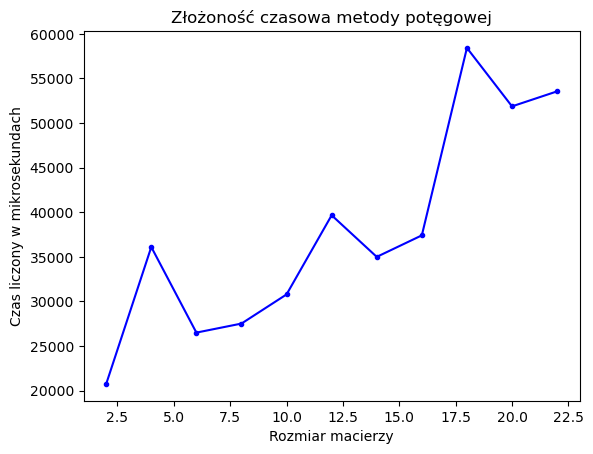

PyObject Text(24.000000000000014, 0.5, 'Czas liczony w mikrosekundach')

In [117]:
plot(i_values, mean_time_potegowa, "b.-")
title("Złożoność czasowa metody potęgowej")
xlabel("Rozmiar macierzy")
ylabel("Czas liczony w mikrosekundach")

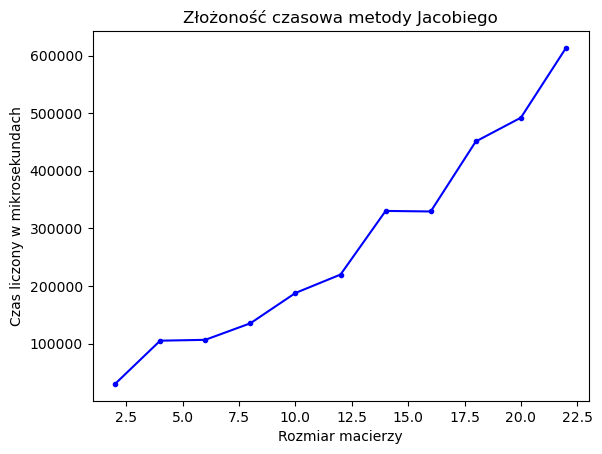

PyObject Text(24.0, 0.5, 'Czas liczony w mikrosekundach')

In [118]:
plot(i_values, mean_time_jacobi, "b.-")
title("Złożoność czasowa metody Jacobiego")
xlabel("Rozmiar macierzy")
ylabel("Czas liczony w mikrosekundach")

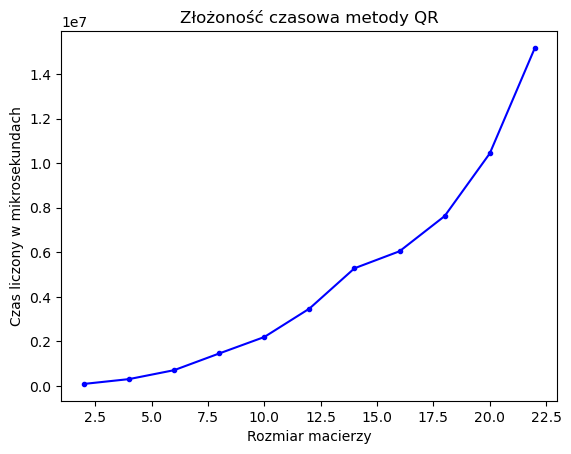

PyObject Text(24.000000000000014, 0.5, 'Czas liczony w mikrosekundach')

In [119]:
plot(i_values, mean_time_qr, "b.-")
title("Złożoność czasowa metody QR")
xlabel("Rozmiar macierzy")
ylabel("Czas liczony w mikrosekundach")

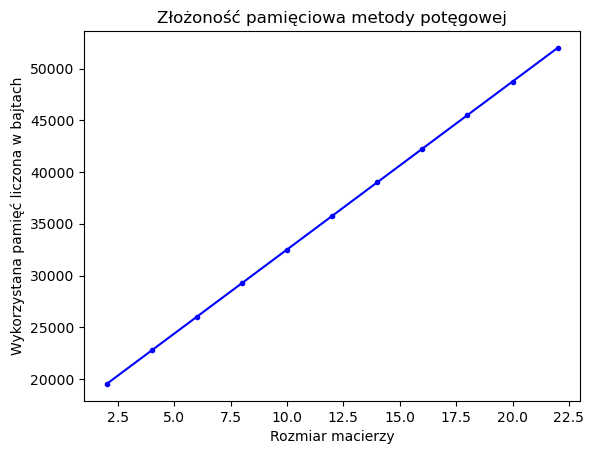

PyObject Text(24.500000000000014, 0.5, 'Wykorzystana pamięć liczona w bajtach')

In [120]:
plot(i_values, mean_memory_potegowa, "b.-")
title("Złożoność pamięciowa metody potęgowej")
xlabel("Rozmiar macierzy")
ylabel("Wykorzystana pamięć liczona w bajtach")

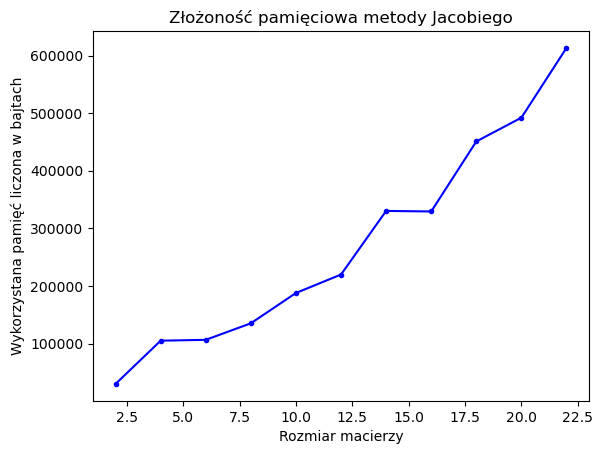

PyObject Text(24.500000000000014, 0.5, 'Wykorzystana pamięć liczona w bajtach')

In [121]:
plot(i_values, mean_time_jacobi, "b.-")
title("Złożoność pamięciowa metody Jacobiego")
xlabel("Rozmiar macierzy")
ylabel("Wykorzystana pamięć liczona w bajtach")

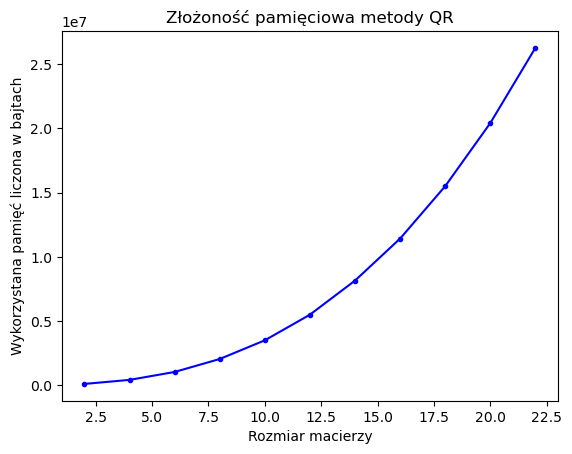

PyObject Text(24.500000000000014, 0.5, 'Wykorzystana pamięć liczona w bajtach')

In [122]:
plot(i_values, mean_memory_qr, "b.-")
title("Złożoność pamięciowa metody QR")
xlabel("Rozmiar macierzy")
ylabel("Wykorzystana pamięć liczona w bajtach")